https://alpaca-gt.tistory.com/manage/newpost/?type=post&returnURL=%2Fmanage%2Fposts%2F
### [DACON] 비지도학습 기반의 이상탐지 활용(feat. 시계열)

#### 1. Libraries LOAD

In [1]:
!pip install /home/ubuntu/coding/220906/eTaPR-1.12-py3-none-any.whl

Processing ./eTaPR-1.12-py3-none-any.whl
eTaPR is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from tqdm.notebook import trange
from TaPR_pkg import etapr
from pathlib import Path
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

#### 2. Data Preprocessing

##### 1) data load

In [3]:
TRAIN_DATASET = sorted([x for x in Path("/home/ubuntu/coding/220906/HAI 2.0/training").glob("*.csv")])
TRAIN_DATASET

[PosixPath('/home/ubuntu/coding/220906/HAI 2.0/training/train1.csv'),
 PosixPath('/home/ubuntu/coding/220906/HAI 2.0/training/train2.csv'),
 PosixPath('/home/ubuntu/coding/220906/HAI 2.0/training/train3.csv')]

In [4]:
TEST_DATASET  = sorted([x for x in Path("/home/ubuntu/coding/220906/HAI 2.0/testing").glob("*.csv")])
TEST_DATASET 

[PosixPath('/home/ubuntu/coding/220906/HAI 2.0/testing/test1.csv'),
 PosixPath('/home/ubuntu/coding/220906/HAI 2.0/testing/test2.csv'),
 PosixPath('/home/ubuntu/coding/220906/HAI 2.0/testing/test3.csv'),
 PosixPath('/home/ubuntu/coding/220906/HAI 2.0/testing/test4.csv')]

In [5]:
VALIDATION_DATASET  = sorted([x for x in Path("/home/ubuntu/coding/220906/HAI 2.0/validation").glob("*.csv")])
VALIDATION_DATASET 

[PosixPath('/home/ubuntu/coding/220906/HAI 2.0/validation/validation.csv')]

In [6]:
def dataframe_from_csv(target):
    return pd.read_csv(target, engine='python').rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [7]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
# TRAIN_DF_RAW = TRAIN_DF_RAW[:30720]
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,...,944.84705,0.0,1.32843,15.17817,35.14710,11.79657,316.89453,296.54950,32.0000,6.6026
478797,2020-08-10 10:59:57,387.52774,12,10,66.72057,-0.9996,-1.84479,787.65070,28.02385,840.0,...,940.49835,0.0,1.32843,15.17344,35.13183,11.79657,315.59247,296.15161,32.0000,6.3894
478798,2020-08-10 10:59:58,387.47665,12,10,66.72057,-1.2560,-1.84479,788.50256,28.03085,792.0,...,935.71472,0.0,1.32919,15.16443,35.13183,11.79657,313.92865,293.40277,32.0000,6.2584
478799,2020-08-10 10:59:59,387.73221,12,10,66.72057,-1.4912,-1.84479,785.80316,28.02649,752.0,...,944.84705,0.0,1.32843,15.09001,35.14710,11.79657,315.61054,302.58972,32.0000,6.4150


##### 2) variables setting

In [8]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

- data Normalization

In [9]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [10]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [11]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [12]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    print(x)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [13]:
boundary_check(TRAIN_DF)

[[0.37895253 0.         0.         ... 0.2650172  1.         0.5672542 ]
 [0.37845883 0.         0.         ... 0.2504694  1.         0.5066231 ]
 [0.37845883 0.         0.         ... 0.25502798 1.         0.46494597]
 ...
 [0.30434805 0.         0.         ... 0.23551878 0.26161984 0.625875  ]
 [0.3068182  0.         0.         ... 0.26957628 0.26161984 0.6820907 ]
 [0.30484188 0.         0.         ... 0.29337597 0.26161984 0.7588398 ]]


(False, False, False)

##### 3) Model

- Autoencoder의 레이어를 LSTM으로 구성하여 시퀸스 학습이 가능
    - !D-Convolution layer를 적용하여 timestamp와 feature 정보를 세밀하게 이동하면서 학습
    -  Conv1D 레이어를 활용하였기 때문에 timestamp는 1로 두고 3 차원의 shpae 형태

In [14]:
def temporalize(X, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(X) - timesteps - 1):
        t = []
        for j in range(1, timesteps + 1):
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

In [15]:
train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(921603, 1, 79)

- Model details
    - Conv1D
        - filters : 컨볼루션 연산의 output 출력 수
        - kernel_size : timestamp를 얼마만큼 볼 것인가( = window_size)
        - padding : 한 쪽 방향으로 얼마만큼 padding할 것인가
        - dilation : kernel 내부에서 얼마만큼의 간격으로 kernel을 적용할 것인가
        - stride : default = 1, 컨볼루션 레이어의 이동크기

    - LSTM
        - unit : 출력 차원층만 설정
        - 모델의 구조
        - Conv1D - Dense층 - LSTM - Dense층으로 encoder 와 decoder가 대칭이 되도록 설계
        - 파라미터는 주로 filters, kernel_size, Dense, LSTM의 units 값을 조절
        - Conv1D 레이어를 추가하거나 maxpooling과 같이 기존의 CNN 모델과 동일한 방식 적용 가능

In [16]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session()

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense(128),
            layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.Dense(64),
            layers.RepeatVector(n_steps),
            layers.Dense(64),
            layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Dense(128),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
        ]
    )
    return model

In [17]:
model1 = conv_auto_model(x_train)
model1.compile(optimizer='adam', loss='mse')
model1.summary()

2022-09-08 08:15:16.021545: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-08 08:15:16.024392: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 512)            2589184   
                                                                 
 dense (Dense)               (None, 1, 128)            65664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 1, 64)             4160      
                                                        

#### 4. Model fit

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

epochs = 3
batch = 64

# fit
history = model1.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2, callbacks=[early_stopping]).history

model1.save('model1.h5')

Epoch 1/3
11521/11521 [==============================] - 3507s 304ms/step - loss: 0.0023 - val_loss: 7.2723e-04
Epoch 2/3
11521/11521 [==============================] - 3862s 335ms/step - loss: 2.0000e-04 - val_loss: 3.5825e-04
Epoch 3/3
11521/11521 [==============================] - 3820s 332ms/step - loss: 1.0430e-04 - val_loss: 3.9436e-04


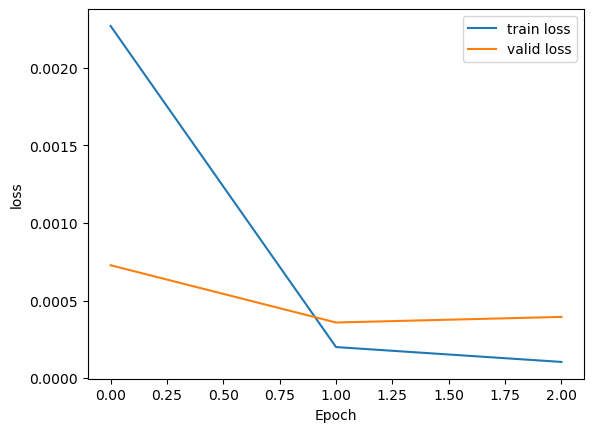

In [19]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

- Model Load

In [20]:
model1.save('best_AutoEncoder_model1.h5') #keras h5

In [21]:
model = load_model('best_AutoEncoder_model1.h5')

#### 5. anomaly detection

- 학습된 모델을 검증 데이터셋에 적용

In [22]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW.to_csv('VALIDATION_DF_RAW.csv')
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


- 검증 데이터 셋에서는 정상 데이터를 기준으로 정규화를 진행

In [23]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [24]:
boundary_check(VALIDATION_DF)

[[0.45158097 0.         0.         ... 0.5797802  0.52712005 0.4013713 ]
 [0.45256948 0.         0.         ... 0.5799144  0.52712005 0.32340166]
 [0.45207536 0.         0.         ... 0.5926521  0.52712005 0.37272498]
 ...
 [0.39772758 0.         0.         ... 0.6184636  0.17970447 0.23875508]
 [0.3997038  0.         0.         ... 0.62228477 0.17970447 0.129734  ]
 [0.401186   0.         0.         ... 0.62047464 0.17970447 0.02301037]]


(True, True, False)

- 시각화로 일정 구간에서 0과 1 범위를 벗어나는 것을 확인

<AxesSubplot:>

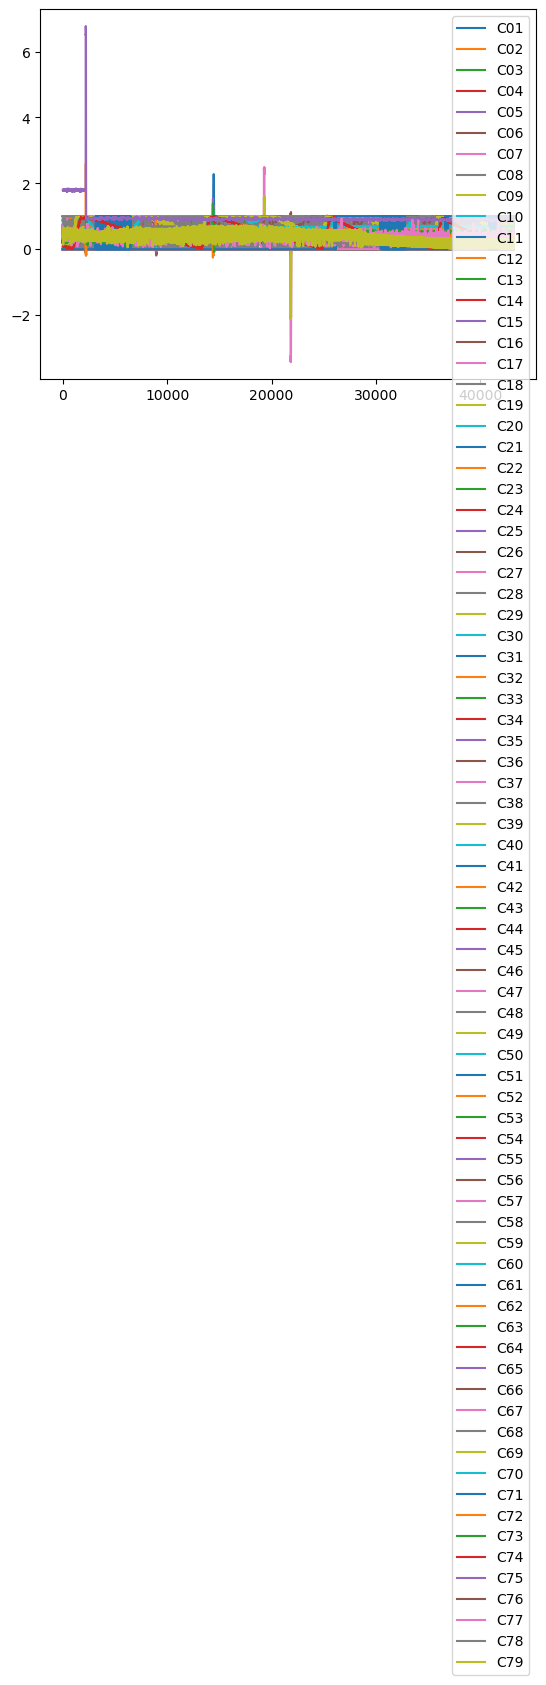

In [25]:
VALIDATION_DF.plot()

<AxesSubplot:>

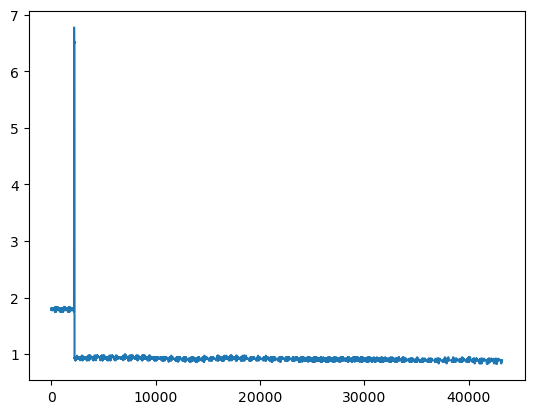

In [26]:
VALIDATION_DF['C75'].plot()

#### 6. Data cleaning
- validation set에서 조금 더 정교하게 threshold 조절 및 결과를 확인하기 위해서 해당 변수의 값을 정상 범위에 맞게 임의로 조절

In [27]:
# valid 그래프를 보고 앞부분 정상인데 값이 튀는 변수가 있어서 조절
VALIDATION_DF['C75'][:2110] = 0.95    

In [28]:
val = np.array(VALIDATION_DF)
x_val = val.reshape(val.shape[0], 1, val.shape[1])
x_val.shape

(43201, 1, 79)

- 모델의 결과가 3차원의 형태이기 때문에 복원된 결과와의 차이를 확인하기 위해서는 2차원으로 다시 바꾸기

In [29]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

- 모델의 의해 재구성된 값을 실제 값과 차이를 구해서 재구성 손실(reconstruction error) 값을 구하기
    - 정상인 경우 모델이 잘 학습되어 복원이 잘 되었기 때문에 reconstruction error 값이 작게 나올 것
    - 공격인 경우 정규화된 값에서 0과 1을 벗어나기 때문에 reconstruction error 값이 크게 나올 것

In [30]:
start = time.time()
valid_x_predictions = model.predict(x_val)
print(valid_x_predictions.shape)

error = flatten(x_val) - flatten(valid_x_predictions)
print((flatten(x_val) - flatten(valid_x_predictions)).shape)

valid_mse = np.mean(np.power(flatten(x_val) - flatten(valid_x_predictions), 2), axis=1)
print(valid_mse.shape)
print(time.time()-start)

(43201, 1, 79)
(43201, 79)
(43201,)
36.89665603637695


#### 7. Precision Recall Curve

- threshold의 경우 Recall과 Precision의 값이 교차되는 지점을 기준

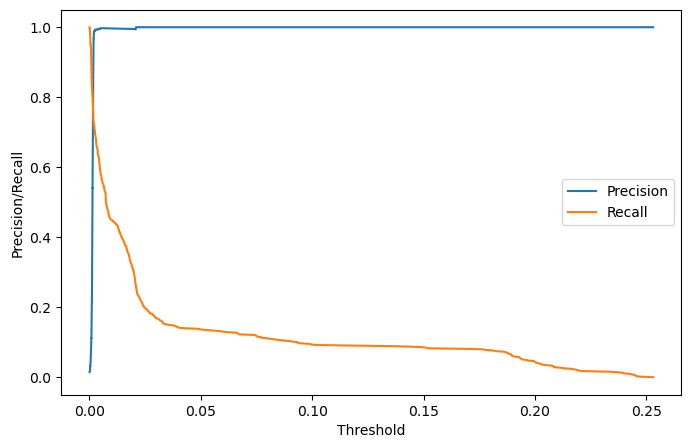

In [31]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse, 'True_class':list(VALIDATION_DF_RAW['attack'])})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
#plt.show()

In [32]:
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.7694753577106518 , recall:  0.7694753577106518
threshold:  0.0016067370062222142
